# Exercise 3. Generating new images with COSDD

As mentioned in the training.ipynb notebook, COSDD is a deep generative model that captures the structures and characteristics of our data. In this notebook, we'll see how accurately it can represent our training data, in both the signal and the noise. We'll do this by using the model to generate entirely new images. These will be images that look like the ones in our training data but don't actually exist. This is the same as how models like DALL-E can generate entirely new images.

In [1]:
import os
import math

import tifffile
import torch
import matplotlib.pyplot as plt
import numpy as np

import utils
from models.lvae import LadderVAE
from models.pixelcnn import PixelCNN
from models.s_decoder import SDecoder
from models.unet import UNet
from models.hub import Hub

%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### 3.1. Load test data
The images that we want to denoise are loaded here.

In [3]:
# Load data
low_snr = utils.load_data(paths="./data",
                          patterns="actin-confocal-lowsnr.tif",
                          axes="SYX",
                          n_dimensions=2)
print(f"Noisy data size: {low_snr.size()}")

Noisy data size: torch.Size([79, 1, 1024, 1024])


### 3.2. Load trained model

In the cell below, we initialise all the model components again. It is important to use the same hyper-parameters that were used in training.ipynb.  Then, the parameters of the model trained in the previous notebook are loaded by setting `model_name`.

In [4]:
crop_size = (256, 256)

dimensions = 2
s_code_channels = 64

n_layers = 8
z_dims = [s_code_channels // 2] * n_layers
min_size = min(crop_size)
num_halves = math.floor(math.log2(min_size)) - 1
downsampling = [1] * n_layers
difference = max(n_layers - num_halves, 0)
i = 0
while difference > 0:
    for j in range(n_layers // 2):
        downsampling[i + j * 2] = 0
        difference -= 1
        if difference == 0:
            break
    i += 1
lvae = LadderVAE(
    colour_channels=low_snr.shape[1],
    img_size=crop_size,
    s_code_channels=s_code_channels,
    n_filters=s_code_channels,
    z_dims=z_dims,
    downsampling=downsampling,
    dimensions=dimensions,
)

ar_decoder = PixelCNN(
    colour_channels=low_snr.shape[1],
    s_code_channels=s_code_channels,
    kernel_size=5,
    noise_direction="x", 
    n_filters=64,
    n_layers=4,
    n_gaussians=5,
    dimensions=dimensions,
)

s_decoder = SDecoder(
    colour_channels=low_snr.shape[1],
    s_code_channels=s_code_channels,
    n_filters=s_code_channels,
    dimensions=dimensions,
)

use_direct_denoiser = True
if use_direct_denoiser:
    direct_denoiser = UNet(
        colour_channels=low_snr.shape[1],
        n_filters=s_code_channels,
        n_layers=n_layers,
        downsampling=downsampling,
        loss_fn="MSE",
        dimensions=dimensions,
    )
else:
    direct_denoiser = None

In [10]:
model_name = "actin-confocal"
checkpoint_path = os.path.join("checkpoints", model_name)
hub = Hub.load_from_checkpoint(os.path.join(checkpoint_path, "final_model.ckpt"),
                               vae=lvae, 
                               s_decoder=s_decoder,
                               ar_decoder=ar_decoder,
                               direct_denoiser=direct_denoiser).to(device)

### 3.2. Generating new noise for a real noisy image

First, we'll pass a noisy image to the VAE and generate a random sample from the AR decoder. This will give us another noisy image with the same underlying clean signal but a different random sample of noise.

`inp_image` (torch.Tensor): The real noisy image we're going to add a different random sample of noise to.<br>
`denoised` (torch.Tensor): The denoised version of `inp_image`.<br>
`noisy` (torch.Tensor): The same underlying signal as `inp_image` but a different sample of noise.

In [11]:
with torch.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=use_cuda):
    inp_image = low_snr[:1, :, :512, :512].to(device)
    reconstructions = hub.reconstruct(inp_image)
    denoised = reconstructions["s_hat"].cpu()
    noisy = reconstructions["x_hat"].cpu()

100%|██████████|


In [12]:
vmin = np.percentile(inp_image.cpu().numpy(), 0.1)
vmax = np.percentile(inp_image.cpu().numpy(), 99.9)

Now we will look at the original noisy image and the generated noisy image. Adjust `top`, `bottom`, `left` and `right` to view different crops of the reconstructed image.

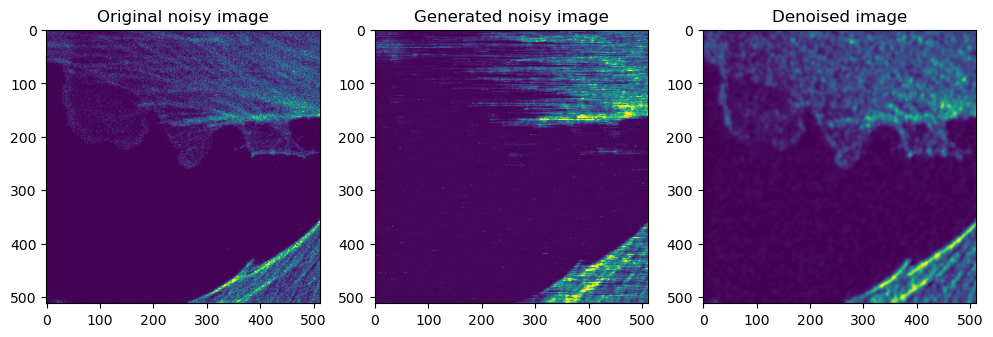

In [13]:
top = 0
bottom = 512
left = 0
right = 512

crop = (0, slice(top, bottom), slice(left, right))

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(inp_image[0][crop].cpu(), vmin=vmin, vmax=vmax)
ax[0].set_title("Original noisy image")
ax[1].imshow(noisy[0][crop], vmin=vmin, vmax=vmax)
ax[1].set_title("Generated noisy image")
ax[2].imshow(denoised[0][crop], vmin=vmin, vmax=vmax)
ax[2].set_title("Denoised image")

plt.show()

The spatial correlation of the generated noise can be compared to that of the real noise to get an idea of how accurate the model is. Since we have the denoised version of the generated image, we can get a noise sample by just subtracting it from the noisy versions.

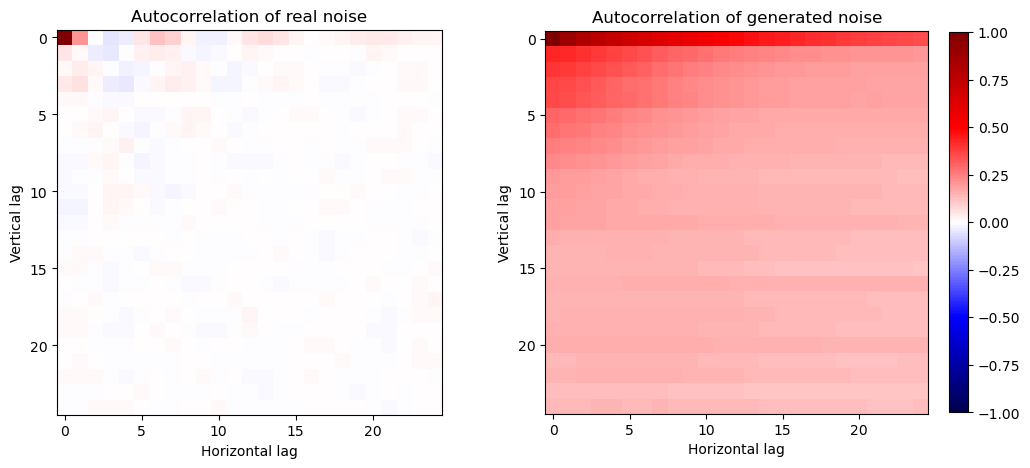

In [14]:
real_noise = low_snr[0, 0, 300:500, :200]
generated_noise = noisy[0, 0] - denoised[0, 0]

real_ac = utils.autocorrelation(real_noise, max_lag=25)
generated_ac = utils.autocorrelation(generated_noise, max_lag=25)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ac1 = ax[0].imshow(real_ac, cmap="seismic", vmin=-1, vmax=1)
ax[0].set_title("Autocorrelation of real noise")
ax[0].set_xlabel("Horizontal lag")
ax[0].set_ylabel("Vertical lag")
ac2 = ax[1].imshow(generated_ac, cmap="seismic", vmin=-1, vmax=1)
ax[1].set_title("Autocorrelation of generated noise")
ax[1].set_xlabel("Horizontal lag")
ax[1].set_ylabel("Vertical lag")

fig.colorbar(ac2, fraction=0.045)
plt.show()

### 3.3. Generating new images

This time, we'll generate a sample from the VAE's prior and use the two decoders to reveal a brand new clean image and its noisy version.

In [15]:
n_imgs = 1
reconstructions = hub.sample_prior(n_imgs=n_imgs)
denoised = reconstructions["s"].cpu()
noisy = reconstructions["x"].cpu()

100%|██████████|


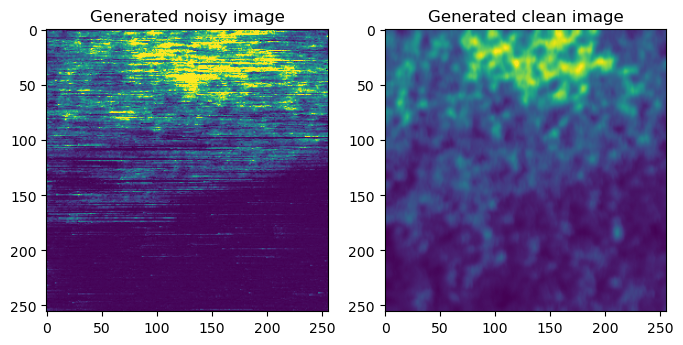

In [16]:
top = 0
bottom = 256
left = 0
right = 256

crop = (0, slice(top, bottom), slice(left, right))

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(noisy[0][crop], vmin=vmin, vmax=vmax)
ax[0].set_title("Generated noisy image")
ax[1].imshow(denoised[0][crop], vmin=vmin, vmax=vmax)
ax[1].set_title("Generated clean image")

plt.show()